In [326]:
# Importing required libraries
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate,cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, space_eval
from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2

# 1. Read data

In [327]:
train_df = pd.read_csv("q1_data_train_data.csv")
test_df = pd.read_csv("q1_data_test_data.csv")

# 2. Exploratory data analysis

In [328]:
# Creating a copy of the dataset for exploration
df = train_df.copy()
df.head()

,radius_0,texture_0,perimeter_0,radius_1,texture_1,perimeter_1,radius_2,texture_2,perimeter_2,age,treatment_date,diagnose_date,cancer_type
0,19.858394,27.204437,136.324256,22.683290,32.802578,119.523841,21.477052,27.3070874472,82.366936,44,2006-06-03,2005-10-23,0
1,14.182069,15.754730,80.916983,14.043753,30.094704,94.911073,15.012329,17.8551305385,103.078286,59,2004-02-22,2007-08-20,1
2,25.380268,21.291553,152.281062,23.852166,46.237931,NaN,28.563252,21.0971528265,143.367792,37,2006-01-06,2004-08-07,0
3,11.835961,17.820702,72.178523,11.260258,44.805167,NaN,12.082749,16.4992370844,65.920413,51,2003-04-14,2005-06-16,1
4,14.875600,17.534187,98.545830,14.380683,26.190447,89.712492,12.930685,19.8566873539,108.380754,21,2004-06-21,2002-11-27,1


By taking a quick glance at the data, we can see that: 
1. There are missing values in the dataset. 
2. The scale of all the columns are different. 

Lets explore this further --

In [329]:
# Lets take a look at the columns in the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   radius_0        398 non-null    float64
 1   texture_0       398 non-null    float64
 2   perimeter_0     398 non-null    float64
 3   radius_1        343 non-null    float64
 4   texture_1       398 non-null    float64
 5   perimeter_1     264 non-null    float64
 6   radius_2        398 non-null    float64
 7   texture_2       398 non-null    object 
 8   perimeter_2     398 non-null    float64
 9   age             398 non-null    int64  
 10  treatment_date  398 non-null    object 
 11  diagnose_date   398 non-null    object 
 12  cancer_type     398 non-null    int64  
dtypes: float64(8), int64(2), object(3)
memory usage: 40.5+ KB


By looking at the column information, we can see that column: radius_1, perimeter_1 has missing values. Also, column texture_2 should be numeric but its of type object. 
Lets convert the texture_2 column to numeric. 

In [330]:
# Changing texture_2 column to numeric. 
df['texture_2'] = pd.to_numeric(df['texture_2'])

ValueError: Unable to parse string "xx" at position 5

Ok, that gave us an error that there are 'xx' strings in one of the rows on the column. Lets try to find these. 

In [331]:
# Filtering texture_2 column to find strings 'xx'
df[df['texture_2'] == 'xx']

,radius_0,texture_0,perimeter_0,radius_1,texture_1,perimeter_1,radius_2,texture_2,perimeter_2,age,treatment_date,diagnose_date,cancer_type
5,11.016351,24.013399,72.373560,12.074242,41.714316,71.440328,11.308987,xx,73.637586,27,2008-07-14,2003-04-26,1
12,210.886211,16.774024,73.647023,9.197132,21.951854,71.546449,11.395254,xx,130.880901,37,2002-01-14,2005-07-02,1
40,19.955770,16.820415,126.139048,17.789452,40.388110,NaN,19.201432,xx,60.852449,42,2005-11-05,2005-11-04,0
48,11.455690,17.652674,60.439946,11.771406,40.927545,84.180340,10.904573,xx,150.622071,26,2005-07-09,2004-09-09,1
54,20.495724,22.229222,125.360417,25.493725,31.806776,145.851300,21.943573,xx,130.469431,36,2008-11-25,2004-05-15,0
72,15.908049,10.167976,109.692652,16.833068,10.318154,NaN,15.358529,xx,84.482714,52,2003-04-19,2006-04-07,0
96,16.706913,22.305935,116.289025,12.345707,36.573538,107.844422,16.432227,xx,49.748754,25,2002-11-14,2003-01-13,0
230,14.465224,13.864701,87.721713,NaN,54.532482,84.038447,12.827003,xx,112.014665,19,2006-09-27,2003-05-18,1
259,12.555254,9.016215,73.243620,NaN,7.292412,78.753971,12.130724,xx,212.634356,18,2004-02-26,2002-09-24,1
267,13.022230,29.243149,67.796381,NaN,4.716045,95.905565,16.617381,xx,187.786346,25,2007-11-15,2003-08-21,1


There are quite a few rows with that error, which could be a human error. We will treat these values as missing values and convert them to Nan. 

In [332]:
# Changing datatype of columns diagnose_date and treatment_date to datatime to do datetime manipulations. Also, changing the dtype of column texture_2 to numeric and converting all the errors to Nan. 
df['diagnose_date'] = pd.to_datetime(df['diagnose_date'])
df['treatment_date'] = pd.to_datetime(df['treatment_date'])
df['texture_2'] = pd.to_numeric(df['texture_2'], errors='coerce')

In [333]:
# Lets take a quick look at the column information again to convert everything is formated correct. Seems like we are good. 

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   radius_0        398 non-null    float64       
 1   texture_0       398 non-null    float64       
 2   perimeter_0     398 non-null    float64       
 3   radius_1        343 non-null    float64       
 4   texture_1       398 non-null    float64       
 5   perimeter_1     264 non-null    float64       
 6   radius_2        398 non-null    float64       
 7   texture_2       382 non-null    float64       
 8   perimeter_2     398 non-null    float64       
 9   age             398 non-null    int64         
 10  treatment_date  398 non-null    datetime64[ns]
 11  diagnose_date   398 non-null    datetime64[ns]
 12  cancer_type     398 non-null    int64         
dtypes: datetime64[ns](2), float64(9), int64(2)
memory usage: 40.5 KB


In [334]:
# Lets quanity the number of missing values. 

df.isnull().sum()

radius_0            0
texture_0           0
perimeter_0         0
radius_1           55
texture_1           0
perimeter_1       134
radius_2            0
texture_2          16
perimeter_2         0
age                 0
treatment_date      0
diagnose_date       0
cancer_type         0
dtype: int64

There are missing values in column radius_1, perimeter_1 and texture_2. Column perimeter_1 has significant number of missing values, we will handle these in the modelling phase by imputing them. 

In [335]:
# Lets also look at the distribution of the target variable. 

df['cancer_type'] = pd.Categorical(df['cancer_type'])
df['cancer_type'].value_counts()

cancer_type
1    250
0    148
Name: count, dtype: int64

The distribution of the target variable is imbalanced too. We will try to build a model using the data as it is, if we dont get good enough score, we will explore resampling techniques to balance out the target. 

In [336]:
# Lets take a quick look at some of the key characteristics of the dataset. 

df.describe()

,radius_0,texture_0,perimeter_0,radius_1,texture_1,perimeter_1,radius_2,texture_2,perimeter_2,age,treatment_date,diagnose_date
count,398.000000,398.000000,398.000000,343.000000,398.000000,264.000000,398.000000,382.000000,398.000000,398.000000,398,398
mean,21.303711,18.957554,92.128890,14.123575,30.417222,94.086379,14.134922,19.459098,127.222422,39.876884,2004-06-03 22:25:55.778894464,2004-12-18 22:47:38.291457280
min,6.401956,-17.243202,45.612505,5.752395,2.395868,43.444930,7.079847,-0.966998,44.918942,18.000000,2000-01-19 00:00:00,2002-01-09 00:00:00
25%,11.693885,14.581364,74.975361,11.600838,19.898062,75.188880,11.573592,15.456557,84.123724,28.000000,2002-03-26 18:00:00,2003-10-07 00:00:00
50%,13.468170,18.238742,87.376764,13.385789,30.897762,90.054613,13.333610,19.436094,129.992697,39.000000,2004-04-30 00:00:00,2005-01-29 12:00:00
75%,16.323024,22.494291,104.876420,16.051640,42.555657,106.085670,16.093900,22.944174,169.538170,50.000000,2006-09-08 06:00:00,2006-02-02 12:00:00
max,561.311068,40.064462,193.755763,29.645166,55.820612,227.162938,28.563252,39.331864,214.192377,64.000000,2008-11-26 00:00:00,2007-11-15 00:00:00
std,49.987646,6.243499,25.159787,3.780636,15.027855,27.314466,3.748146,5.802189,49.097558,13.427196,NaN,NaN


A few things standout here: 
1. There are negative values in the dataset. Not sure, if its a data error or its ok from a business standpoint to have these negative values. For example, there are negative values in column texture_0 and texture_2. 
2. Minimum treatment_date is less than the minimum diagnose_date. Looks like a data quality issue, as treatment date should be after diagnose_date, we will explore this. 

In [322]:
# Creating a new column, that calculates number of days from when a patient was diagnosed to the date that patient was treated. 

df['diag_to_treat_time'] = (df['treatment_date'] - df['diagnose_date']).dt.days
df[[ 'diagnose_date','treatment_date', 'diag_to_treat_time']].head(20)

,diagnose_date,treatment_date,diag_to_treat_time
0,2005-10-23,2006-06-03,223
1,2007-08-20,2004-02-22,-1275
2,2004-08-07,2006-01-06,517
3,2005-06-16,2003-04-14,-794
4,2002-11-27,2004-06-21,572
5,2003-04-26,2008-07-14,1906
6,2005-09-21,2007-10-23,762
7,2005-04-19,2003-04-27,-723
8,2005-11-07,2005-03-08,-244
9,2006-04-07,2000-04-23,-2175


Interestingly, there are patients who were treated before they were diagnosed?? 
Looks like an data error, but I am not sure maybe the diagnose and treatment date columns are mislabbeled. What we can do is to take a abolsute of these values, and use this column as a feature for our model. 

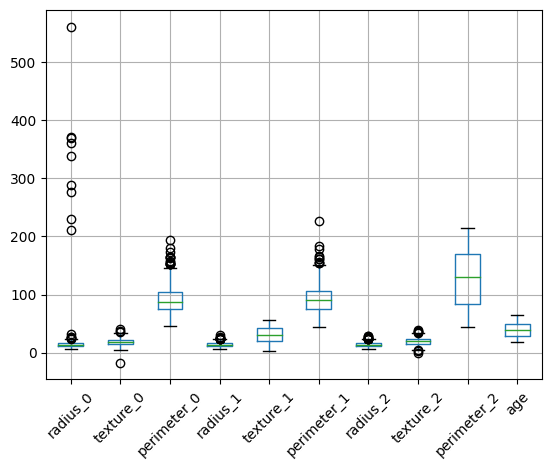

In [323]:
#  Outliers: Lets take a look at the box plot of all the columns to see if there are any outliers in the dataset. 

df.drop(columns='diag_to_treat_time', inplace=True)
df.boxplot(grid=True, rot=45, fontsize=10)
plt.show()

As you can see in the plot above, almost all the columns have examples outside the IQR range but we cannot be sure if these are outliers or actual observations. For our modelling exercise, we will keep these examples as it is. 

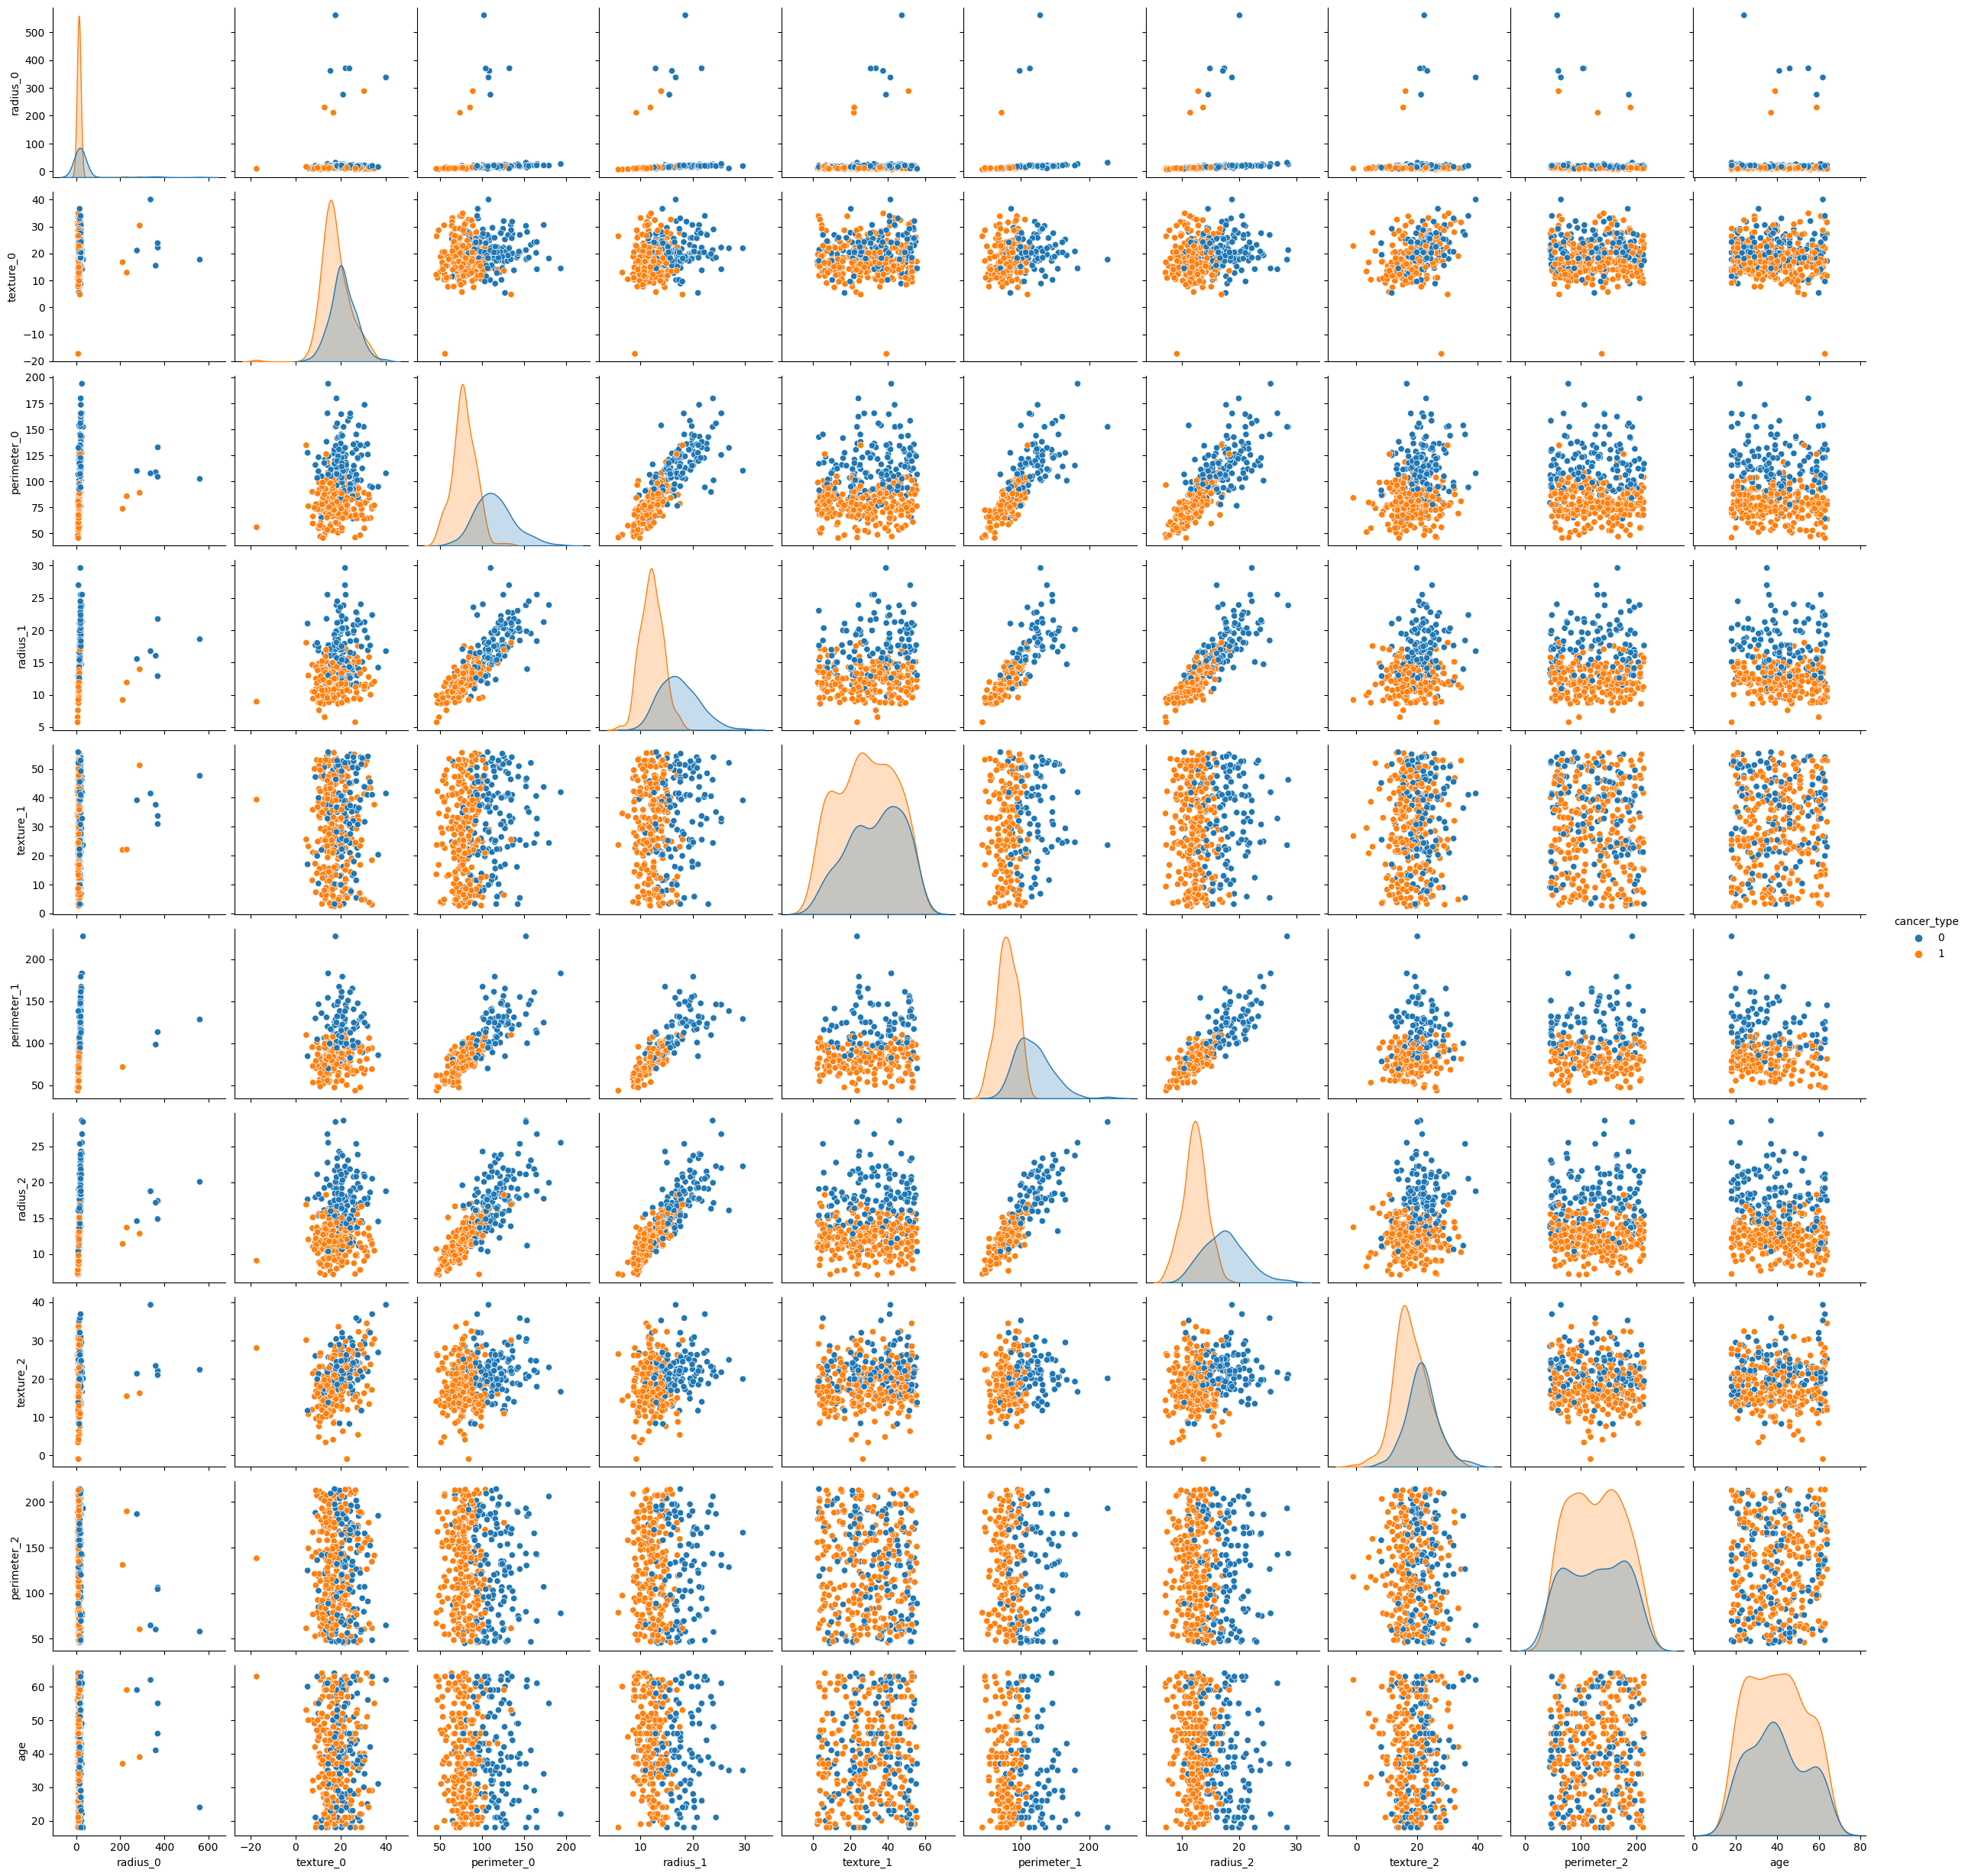

In [324]:
# Ok, Lets create a pairpot to understand relationships between different variables in our dataset. 

sns.pairplot(data=df,  hue='cancer_type')
plt.show()

Key takeaways from this plot:
1. If we look at the distribution of each input variable with respect to the target variable, we can see a clear distincation in the distribution. That means that these inputs are good predictions and can be a good choice of feature to differenciate between the different cancer types. 
2. Some input variables have strong positive correlations with each other. For example, radius_2 and perimeter_1 has strong positive corelation. Lets explore these correlations further 

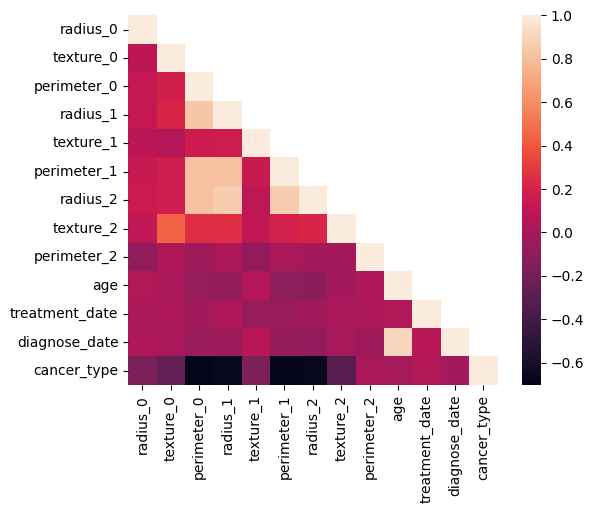

In [282]:
# Creating a correlation map to study correlations between different features
corr_mat = df.corr()
mask = np.array(corr_mat)
mask[np.tril_indices_from(mask)] = False
sns.heatmap(df.corr(), mask=mask, square=True, cbar=True)
plt.show()

Takeaways: 

Strong corelations exist between variables perimeter_0 ,perimter_1, radius_1 and radius_2 as seen in the graph above. 

## 2.1 Key take aways from the data exploration exercise and proposed solutions :

* Texture_2 column has rows with 'xx' -> We will replace xx with Nan. 
* Some columns like texture_2, diagnose_date and treatment_date has incorrect datatypes -> Process columns to change the datatype to correct type. 
* From the boxplots, it seems like there are outliers in the dataset, but we are not sure if they are indeed outliers -> Keep them as it is. 
* Some columns have negative values -> keep them as it is
* Columns radius_1, perimeter_1 and texture_2 has missing values -> Since our dataset is small, we will impute these missing values. 
* Target imbalance -> We will use resampling methods to upsample the 0 class examples. 
* Some patients are treated before they are diagnosed -> We will take absolute of the different and use it as a feature. 

-----------------------------------------------------------------------------------------------------------------------------------------------------

# 3. Prepare data for machine learning

## 3.1 Data cleaning

* Assign correct dtypes. 
* Encode target variable
* Remove'xx' from texture_2 column
* create a new feature to calculate days to treatment from diagnosis and use abs of the values. 

In [284]:
def clean_data(df):
    # change type
    df['diagnose_date'] = pd.to_datetime(df['diagnose_date'])
    df['treatment_date'] = pd.to_datetime(df['treatment_date'])
    # change type and replace 'xx' with Nan. 
    df['texture_2'] = pd.to_numeric(df['texture_2'], errors='coerce')
    # Create a new column to calculate days to treatment from diagnoses
    df['diag_to_treat_time'] = (df['treatment_date'] - df['diagnose_date']).dt.days
    # take absolute of the values
    df['diag_to_treat_time'] = df['diag_to_treat_time'].abs()
    return df
    

In [285]:
# Clean both test and training dataset.
train_df_cleaned = clean_data(train_df)
test_df_cleaned = clean_data(test_df)

In [286]:
test_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171 entries, 0 to 170
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   radius_0            171 non-null    float64       
 1   texture_0           171 non-null    float64       
 2   perimeter_0         171 non-null    float64       
 3   radius_1            146 non-null    float64       
 4   texture_1           171 non-null    float64       
 5   perimeter_1         105 non-null    float64       
 6   radius_2            171 non-null    float64       
 7   texture_2           159 non-null    float64       
 8   perimeter_2         171 non-null    float64       
 9   age                 171 non-null    int64         
 10  treatment_date      171 non-null    datetime64[ns]
 11  diagnose_date       171 non-null    datetime64[ns]
 12  diag_to_treat_time  171 non-null    int64         
dtypes: datetime64[ns](2), float64(9), int64(2)
memory 

In [325]:
train_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   radius_0            398 non-null    float64
 1   texture_0           398 non-null    float64
 2   perimeter_0         398 non-null    float64
 3   radius_1            343 non-null    float64
 4   texture_1           398 non-null    float64
 5   perimeter_1         264 non-null    float64
 6   radius_2            398 non-null    float64
 7   texture_2           382 non-null    float64
 8   perimeter_2         398 non-null    float64
 9   age                 398 non-null    int64  
 10  cancer_type         398 non-null    int64  
 11  diag_to_treat_time  398 non-null    int64  
 12  mean_radius         398 non-null    float64
 13  mean_texture        398 non-null    float64
 14  mean_perimeter      398 non-null    float64
dtypes: float64(12), int64(3)
memory usage: 46.8 KB


## 3.2 Feature engineering. 

From the pairplot, it looks like these features will be good predictors. And you would need from contextual and business knowledge to engineer powerful features that could be used to predict whether a cancer to malginant or benign. 
One thing we can do is to create 3 new features that are just average of radius, texture and perimeter. 

* Create three new features : mean_radius, mean_texture and mean_perimeter.
* Drop treatment_date and diagnose_date


In [288]:
def feature_engineering(df):
    #mean radius
    df['mean_radius'] = df[['radius_0', 'radius_1', 'radius_2']].mean(axis=1)
    # mean texture
    df['mean_texture'] = df[['texture_0', 'texture_1', 'texture_2']].mean(axis=1)
    # mean perimeter
    df['mean_perimeter'] = df[['perimeter_0', 'perimeter_1', 'perimeter_2']].mean(axis=1)
    # drop dates
    df.drop(columns=['treatment_date', 'diagnose_date'], inplace=True)
    return df
    

In [289]:
train_df_cleaned_prep = feature_engineering(train_df_cleaned)
test_df_cleaned_prep = feature_engineering(test_df_cleaned)

In [290]:
train_df_cleaned_prep.head()

,radius_0,texture_0,perimeter_0,radius_1,texture_1,perimeter_1,radius_2,texture_2,perimeter_2,age,cancer_type,diag_to_treat_time,mean_radius,mean_texture,mean_perimeter
0,19.858394,27.204437,136.324256,22.683290,32.802578,119.523841,21.477052,27.307087,82.366936,44,0,223,21.339579,29.104701,112.738344
1,14.182069,15.754730,80.916983,14.043753,30.094704,94.911073,15.012329,17.855131,103.078286,59,1,1275,14.412717,21.234855,92.968781
2,25.380268,21.291553,152.281062,23.852166,46.237931,NaN,28.563252,21.097153,143.367792,37,0,517,25.931895,29.542212,147.824427
3,11.835961,17.820702,72.178523,11.260258,44.805167,NaN,12.082749,16.499237,65.920413,51,1,794,11.726323,26.375036,69.049468
4,14.875600,17.534187,98.545830,14.380683,26.190447,89.712492,12.930685,19.856687,108.380754,21,1,572,14.062323,21.193774,98.879692


# 4. Modelling
1. Create a pipeline for: 
* Imputing missing data
* Scaling input data

2. Create a baseline with a simple classification model

3. Spot test different algorithms to choose the best one. 

4. Use hyperparameter tuning to finetune the best model. 

Metric: Recall, F1 score. 

Since we have very limited training examples, we will use cross validation to validate our model

In [166]:
y = train_df_cleaned_prep['cancer_type']
X = train_df_cleaned_prep.drop(columns=['cancer_type'])

In [168]:
# selecting all column names for imputation and scaling
numerical_columns = X.columns.to_list()

In [345]:
# Creating a pipeline to impute and scale input variables. 
numerical_pipeline = Pipeline(
steps=[
    ("imputer", SimpleImputer(strategy='median')),# Since there are a lot of outliers in the data, we will use median to import the data
    ("scaler", StandardScaler())
])

col_transformer = ColumnTransformer(
transformers=[
    ("numerical", numerical_pipeline, numerical_columns)
], 
remainder='passthrough')

In [340]:
#Transforming training dataset

X_prepared = col_transformer.fit_transform(X)

In [183]:
# Baseline model : Logistic regression. Creating a baseline model with logistic regression with default hyperparameters.

baseline = LogisticRegression()

scoring = {'accuracy': 'accuracy',
           'precision': 'precision',
           'recall': 'recall',
           'f1':'f1'}

scores = cross_validate(baseline, X_prepared, y, cv=10, scoring=scoring)
print(f"Average accuracy score: {scores['test_accuracy'].mean()}")
print(f"Average precision score: {scores['test_precision'].mean()}")
print(f"Average recall score: {scores['test_recall'].mean()}")
print(f"Average F1 score: {scores['test_f1'].mean()}")

Average accuracy score: 0.8767948717948718
Average precision score: 0.8932156379075419
Average recall score: 0.916
Average F1 score: 0.90350805963411


We get some good results. The baseline model is able to score more than 90 percent recall at 89 percent precision with 90 % F1 score.
For a model like this, where we are trying detect whether a patient has cancer or not, recall would be a good metric since we reduce the chance of false negatives. 
For our exercise, since we have good features that can differentiate between between malignant and benign cancer, we will try to optimize both precision and recall and use F1 metric to optimize our model.


In [239]:
# Lets spot check different classification algorithms to see which one performs best on our data. 

models = []
models.append(('LR', LogisticRegression()))
models.append(('SVM', SVC()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('XGB', XGBClassifier()))
models.append(('GBR', GradientBoostingClassifier()))


# evaluate each model in turn
results = []
names = []

for name, model in models:    
    cv_results = cross_validate(model, X_prepared, y, cv=10, scoring='f1', return_train_score=True)
    results.append(cv_results)
    names.append(name)
    print("%s %s: %f (%f)" % ("Train",name, cv_results['train_score'].mean(), cv_results['train_score'].std()))
    print("%s %s: %f (%f)" % ("Test",name, cv_results['test_score'].mean(), cv_results['test_score'].std()))

Train LR: 0.919459 (0.007025)
Test LR: 0.903508 (0.037430)
Train SVM: 0.937839 (0.003664)
Test SVM: 0.903701 (0.030578)
Train DT: 1.000000 (0.000000)
Test DT: 0.862270 (0.034789)
Train RF: 1.000000 (0.000000)
Test RF: 0.905249 (0.044621)
Train XGB: 1.000000 (0.000000)
Test XGB: 0.890738 (0.038567)
Train GBR: 1.000000 (0.000000)
Test GBR: 0.914430 (0.031683)


Most of the tree based algorithms are overfitting the data since we have limited data and our data might be too simple for the tree based algorithms.  Support Vector Classifer seems to be performing well. 
Lets try to optimize it using hyperparameter tuning and feature selection. 

In [263]:
# Feature selection: 

# We will use a simple logistic regression model to select the most important features from our dataset. 

selector = SelectFromModel(estimator=LogisticRegression()).fit(X_prepared, y)
X_prepared_filtered = selector.transform(X_prepared)

In [264]:
# Hyper parameter optimization: Here we are using baysian optimization to select the best hyperparameters for the Support Vector Classifier that gives us the highest F1 score on the filtered data. 


def objective(space):
    
    print("===================")
    model = SVC(**space)
    cv_results = cross_validate(model, X_prepared_filtered, y, scoring='f1', cv=10, return_train_score=True)
    print("Train :", cv_results['train_score'].mean())
    print("Test :", cv_results['test_score'].mean())
    
    best_score = cv_results['test_score'].mean()
    loss = - best_score
    
    return {'loss': loss, 'status': STATUS_OK}

space ={
      'C': hp.choice('C', np.arange(0.005,1.0,0.01)),
      'kernel': hp.choice('kernel',['linear', 'poly', 'rbf']),
      'degree':hp.choice('degree',[2,3,4]),
      'probability':hp.choice('probability',[True, False])
      }


trials = Trials()

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials)

print(best)

Train :                                               
0.8041403590822765                                    
Test :                                                
0.7981090255627985                                    
Train :                                                                          
0.8834452158034797                                                               
Test :                                                                           
0.8785361396452404                                                               
Train :                                                                          
0.7749286720800218                                                               
Test :                                                                           
0.775278540903541                                                                
Train :                                                                          
0.9237760976859587                        

In [265]:

print(space_eval(space, best))

{'C': 0.6549999999999999, 'degree': 3, 'kernel': 'rbf', 'probability': True}


Using hyperopt, we are able to score 91% F1 on test, and 92% F1 on train. 

Lets test the best parameters on our model  to replicate the results. 

In [292]:
best_model = SVC(C=0.65, kernel='rbf', degree=3, probability=True)
scoring = {'accuracy': 'accuracy',
           'precision': 'precision',
           'recall': 'recall',
           'f1':'f1'}
scores = cross_validate(best_model, X_prepared_filtered, y, cv=10, scoring=scoring, return_train_score=True)
print(f"Average accuracy score: {scores['test_accuracy'].mean()}")
print(f"Average precision score: {scores['test_precision'].mean()}")
print(f"Average recall score: {scores['test_recall'].mean()}")
print(f"Average F1 score: {scores['test_f1'].mean()}")


Average accuracy score: 0.8918589743589743
Average precision score: 0.8801463099833754
Average recall score: 0.9640000000000001
Average F1 score: 0.918568966857535


**We are indeed able to bump up the performance of our model to 92% F1 score and 96% recall, which makes it a good model for our usecase** 

In [296]:
# Prepare and score on the test data
test_prepared = col_transformer.transform(test_df_cleaned_prep)
test_prepared_filtered = selector.transform(test_prepared)
best_model.fit(X_prepared_filtered, y)
results = best_model.predict(test_prepared_filtered)

In [297]:
results

array([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1])

In [342]:
result_df = pd.DataFrame(results, columns=['cancer_type'])

In [344]:
result_df.to_excel("bms.xlsx")